In [107]:
from environment import Environment
from discreteAgent import Agent
from discreteTrainer import Final_variational_trainer, Q_learning_trainer
import matplotlib.pyplot as plt
import numpy as np
import math

In [108]:
import json
from easydict import EasyDict
from datetime import date
import os
import torch

# Environment Params

In [109]:
args = EasyDict()
args.ENV_NAME = 'VolleyBall' #'Pendulum-v0' #'CartPole-v1' #'MountainCar-v0' #'FrozenLake-v0' #
args.continuous = False

In [110]:
# Biais optimiste : p+ 0.7; p- 0.3; 
# Biais pessimiste : p+ 0.1; p- 0.5; 
# Pas de biais ? : p+ 0.9; p- 0.5; 

# Hypothèse supplémentaire : le score est biaisé en faveur de l'action la plus testée (outcome "hybride" -1/0/1)

p_intervention = 0.7
p_control = 0.3
env = Environment.volleyBall(p_control, p_intervention, initial_state_range=0)

In [111]:
# intervention, control
# (play       , not play)

conditions = {1: (0.7, 0.4), # 0.3
              2: (0.4, 0.7), #-0.3
              3: (0.7, 0.1), # 0.6
              4: (0.2, 0.8), #-0.6
              5: (0.4, 0.4), # 0
              6: (0.1, 0.7), #-0.6
              7: (0.6, 0.3), # 0.3
              8: (0.8, 0.5), # 0.3
              9: (0.6, 0.6), # 0
              10:(0.3, 0.9), #-0.6
              11:(0.9, 0.3), # 0.6
              12:(0.3, 0.6), #-0.3
              13:(0.5, 0.8), #-0.3
              14:(0.8, 0.2), # 0.6
              15:(0.5, 0.5)} # 0

In [112]:
#sorted_keys = (4, 10, 12, 2, 13, 5, 15, 9, 7, 1, 8, 3, 14)
sorted_keys = range(1,16)

In [113]:
env.N_obs

2

# Trainer Params

In [114]:
args.monte_carlo = False
args.augmentation = True
args.final = True 

In [115]:
NULL_POLICY = False

In [116]:
ALPHA_STAR = 0.3 # le alpha qui sert de reference pour OBS_LEAK
BETA_REF = 1 # amplification du reward

k = 1 #0.5  # poids relatif des 2 termes dans la mise à jour explo/exploit
         # (ou taux de regularisation si pas de reward)

args.PREC = k / BETA_REF  

ALPHA_REF =  ALPHA_STAR * args.PREC # le alpha qui sert à apprendre Q_ref (PREC inclus)
print('ALPHA_REF', ALPHA_REF)

args.Q_VAR_MULT = 1

if NULL_POLICY:
    args.ALPHA = 0
else:
    args.ALPHA = ALPHA_STAR / args.Q_VAR_MULT

args.OBS_LEAK = ALPHA_STAR / env.N_obs 
# OBS_LEAK regule la valeur de KL (si faible : atténue les 

ALPHA_REF 0.3


In [117]:
args.ALPHA, args.PREC, args.OBS_LEAK

(0.3, 1.0, 0.15)

# Agent Params

In [118]:
args.isTime = True
args.offPolicy = False
args.BETA = BETA_REF 

args.GAMMA = 1
args.do_reward = None
try:
    args.HIST_HORIZON = 200 * int(1/args.OBS_LEAK)
except:
    args.HIST_HORIZON = 1000

args.KL_centering = True
args.rtg_centering = True

# Data path

In [119]:
data_path = "data/{}/{}-{}".format(args.ENV_NAME,str(date.today()),args.ENV_NAME)
if not args.final:
    data_path += '-full'
else:
    data_path += '-final'
if args.do_reward:
    data_path += '-do-reward'
else:
    data_path += '-no-reward'

data_path += '-LEAK-{}'.format(args.OBS_LEAK)
data_path += '-GAMMA-{}'.format(args.GAMMA)
data_path += '-BETA-{}'.format(args.BETA)
data_path += '-PREC-{}'.format(args.PREC)
data_path += '-ALPHA-{}'.format(ALPHA_REF)


In [120]:
data_path_npy = data_path+'.npy'
data_path_json = data_path+'.json'

In [121]:
if not os.path.isfile(data_path_json):
    with open(data_path_json, 'w') as fp:
        json.dump(args, fp)

In [122]:
data_path_npy

'data/VolleyBall/2021-06-15-VolleyBall-final-no-reward-LEAK-0.15-GAMMA-1-BETA-1-PREC-1.0-ALPHA-0.3.npy'

In [123]:
NB_TRIALS = 40 # Number of episodes
NB_SESSIONS = 50

In [124]:
args.do_reward = True #False  #
verbose = False

In [125]:
mem_Q_var = {}
mem_Q_ref = {}
mem_total_reward = {}
nb_visits_final = {}
mem_act = {}
agent = {}
trainer = {}
env = {}

In [126]:
for c_id in conditions: 

    p_intervention = conditions[c_id][0]
    p_control = conditions[c_id][1]
    env[c_id] = Environment.volleyBall(p_control, p_intervention, initial_state_range=0)

    for session in range(NB_SESSIONS):
        mem_Q_var[c_id, session] = []
        mem_Q_ref[c_id, session] = []
        BETA= args.BETA
        agent[c_id, session] = Agent(env[c_id],
                      ALPHA=args.ALPHA,
                      GAMMA=args.GAMMA, # Episodic agent!
                      BETA=BETA, 
                      PREC=args.PREC,
                      do_reward=args.do_reward,
                      isTime=args.isTime,    #!! TimeAgent
                      offPolicy=False,
                      Q_VAR_MULT=args.Q_VAR_MULT) 
        if k < 1:
            trainer[c_id, session] = Final_variational_trainer(agent[c_id, session], 
                                                monte_carlo=args.monte_carlo, 
                                                final= args.final,
                                                augmentation=args.augmentation,
                                                OBS_LEAK=args.OBS_LEAK,
                                                ref_prob='unif',
                                                KL_centering=args.KL_centering,
                                                rtg_centering=args.rtg_centering) #[2,5] # 
        else:
            trainer[c_id, session] = Q_learning_trainer(agent[c_id, session], 
                                                monte_carlo=args.monte_carlo, 
                                                final= args.final,
                                                augmentation=args.augmentation,
                                                OBS_LEAK=args.OBS_LEAK,
                                                ref_prob='unif',
                                                KL_centering=args.KL_centering,
                                                rtg_centering=args.rtg_centering) #[2,5] # 
        mem_total_reward[c_id, session] = {}
        nb_visits_final[c_id, session] = {}
        mem_act[c_id, session] = []
        for trial in range(NB_TRIALS):

            trainer[c_id, session].run_episode(verbose=verbose)
            mem_Q_var[c_id, session].append(np.array(agent[c_id, session].Q_var_tab))
            mem_Q_ref[c_id, session].append(np.array(agent[c_id, session].Q_ref_tab))     

            if trial%100 == 0:
                print(f'c_id : {c_id}, session: {session}, trial: {trial}')
                print("Trajectory: ", trainer[c_id, session].trajectory)
                print("Total reward got: %.4f" % trainer[c_id, session].total_reward)
                obs = env[c_id].state
                print(np.mean(trainer[c_id, session].obs_score), trainer[c_id, session].obs_score[obs])

            mem_total_reward[c_id, session][trial] = trainer[c_id, session].mem_total_reward
            nb_visits_final[c_id, session][trial] = trainer[c_id, session].nb_visits_final
            mem_act[c_id, session] += trainer[c_id, session].action_history

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


c_id : 1, session: 0, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 1, session: 1, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 1, session: 2, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 1, session: 3, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 1, session: 4, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 1, session: 5, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 1, session: 6, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 1, session: 7, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 1, session: 8, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 1, session: 9, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 1, session: 10, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 1, session: 11, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.000

c_id : 3, session: 0, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 3, session: 1, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 3, session: 2, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 3, session: 3, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 3, session: 4, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 3, session: 5, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 3, session: 6, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 3, session: 7, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 3, session: 8, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 3, session: 9, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 3, session: 10, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 3, session: 11, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.000

c_id : 5, session: 9, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 5, session: 10, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 5, session: 11, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 5, session: 12, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 5, session: 13, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 5, session: 14, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 5, session: 15, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 5, session: 16, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 5, session: 17, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 5, session: 18, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 5, session: 19, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 5, session: 20, trial: 0
Trajectory:  [0, 0]
Total reward g

c_id : 7, session: 13, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 7, session: 14, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 7, session: 15, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 7, session: 16, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 7, session: 17, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 7, session: 18, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 7, session: 19, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 7, session: 20, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 7, session: 21, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 7, session: 22, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 7, session: 23, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 7, session: 24, trial: 0
Trajectory:  [0, 1]
Total reward 

c_id : 9, session: 18, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 9, session: 19, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 9, session: 20, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 9, session: 21, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 9, session: 22, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 9, session: 23, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 9, session: 24, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 9, session: 25, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 9, session: 26, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 9, session: 27, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 9, session: 28, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 9, session: 29, trial: 0
Trajectory:  [0, 0]
Total reward 

c_id : 11, session: 15, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 11, session: 16, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 11, session: 17, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 11, session: 18, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 11, session: 19, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 11, session: 20, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 11, session: 21, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 11, session: 22, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 11, session: 23, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 11, session: 24, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 11, session: 25, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 11, session: 26, trial: 0
Trajectory:  [0, 0]
T

c_id : 13, session: 13, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 13, session: 14, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 13, session: 15, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 13, session: 16, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 13, session: 17, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 13, session: 18, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 13, session: 19, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 13, session: 20, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 13, session: 21, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 13, session: 22, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 13, session: 23, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 13, session: 24, trial: 0
Trajectory:  [0, 0]
T

c_id : 15, session: 21, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 15, session: 22, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 15, session: 23, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 15, session: 24, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 15, session: 25, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 15, session: 26, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 15, session: 27, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 15, session: 28, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 15, session: 29, trial: 0
Trajectory:  [0, 0]
Total reward got: 0.0000
0.5 1.0
c_id : 15, session: 30, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 15, session: 31, trial: 0
Trajectory:  [0, 1]
Total reward got: 1.0000
0.5 1.0
c_id : 15, session: 32, trial: 0
Trajectory:  [0, 1]
T

In [127]:
obs = agent[c_id, session].get_observation()
print(trainer[c_id, session].obs_score)
print(np.mean(trainer[c_id, session].obs_score), trainer[c_id, session].obs_score[obs])

[1.62801119 5.02864013]
3.3283256625003608 5.028640133904159


In [128]:
mem_obs_score = {}
mem_p_eff = {}
mem_KL = {}
mem_DP_val = {}
mem_DP_ref = {}
mem_DP_leak = {}

In [129]:
for c_id in conditions: 
    for session in range(NB_SESSIONS):
        mem_obs_score[c_id, session] = np.zeros((env[c_id].N_obs, trainer[c_id, session].nb_trials))
        mem_p_eff[c_id, session] = np.zeros((env[c_id].N_obs, trainer[c_id, session].nb_trials))
        mem_KL[c_id, session] = np.zeros(trainer[c_id, session].nb_trials)
        mem_obs_score[c_id, session][trainer[c_id, session].mem_obs_final[0],0] = 1
        mem_DP_val[c_id, session] = np.zeros(trainer[c_id, session].nb_trials)
        mem_DP_ref[c_id, session] = np.zeros(trainer[c_id, session].nb_trials)
        mem_DP_leak[c_id, session] = np.zeros(trainer[c_id, session].nb_trials)
        for t in range(1,trainer[c_id, session].nb_trials):
            obs = trainer[c_id, session].mem_obs_final[t]
            mem_obs_score[c_id, session][:,t] = mem_obs_score[c_id, session][:,t-1] * (1 - args.OBS_LEAK)
            mem_obs_score[c_id, session][obs,t] += 1
            mem_p_eff[c_id, session][:,t] = mem_obs_score[c_id, session][:,t] / np.sum(mem_obs_score[c_id, session][:,t])
            mem_KL[c_id, session][t] = np.log(mem_p_eff[c_id, session][obs,t]) - np.log(trainer[c_id, session].ref_probs[obs])
            mem_DP_leak[c_id, session][t] = mem_DP_leak[c_id, session][t-1] * (1 - args.OBS_LEAK / env[c_id].N_obs)
            if mem_act[c_id, session][t] == 0: #control
                mem_DP_val[c_id, session][t] = -obs 
                mem_DP_ref[c_id, session][t] = env[c_id].N_obs * np.mean(mem_DP_val[c_id, session][:t+1]) 
                mem_DP_leak[c_id, session][t] -= obs * args.OBS_LEAK 
            else:
                mem_DP_val[c_id, session][t] = obs 
                mem_DP_ref[c_id, session][t] = env[c_id].N_obs * np.mean(mem_DP_val[c_id, session][:t+1]) 
                mem_DP_leak[c_id, session][t] += obs * args.OBS_LEAK 

In [130]:
import seaborn
seaborn.set()

In [131]:
mem_Q_var_flat = {}
for c_id in conditions: 
    for session in range(NB_SESSIONS):
        mem_Q_var_arr = np.array(mem_Q_var[c_id, session])
        mem_Q_var_flat[c_id, session] = mem_Q_var_arr.reshape((NB_TRIALS, -1))

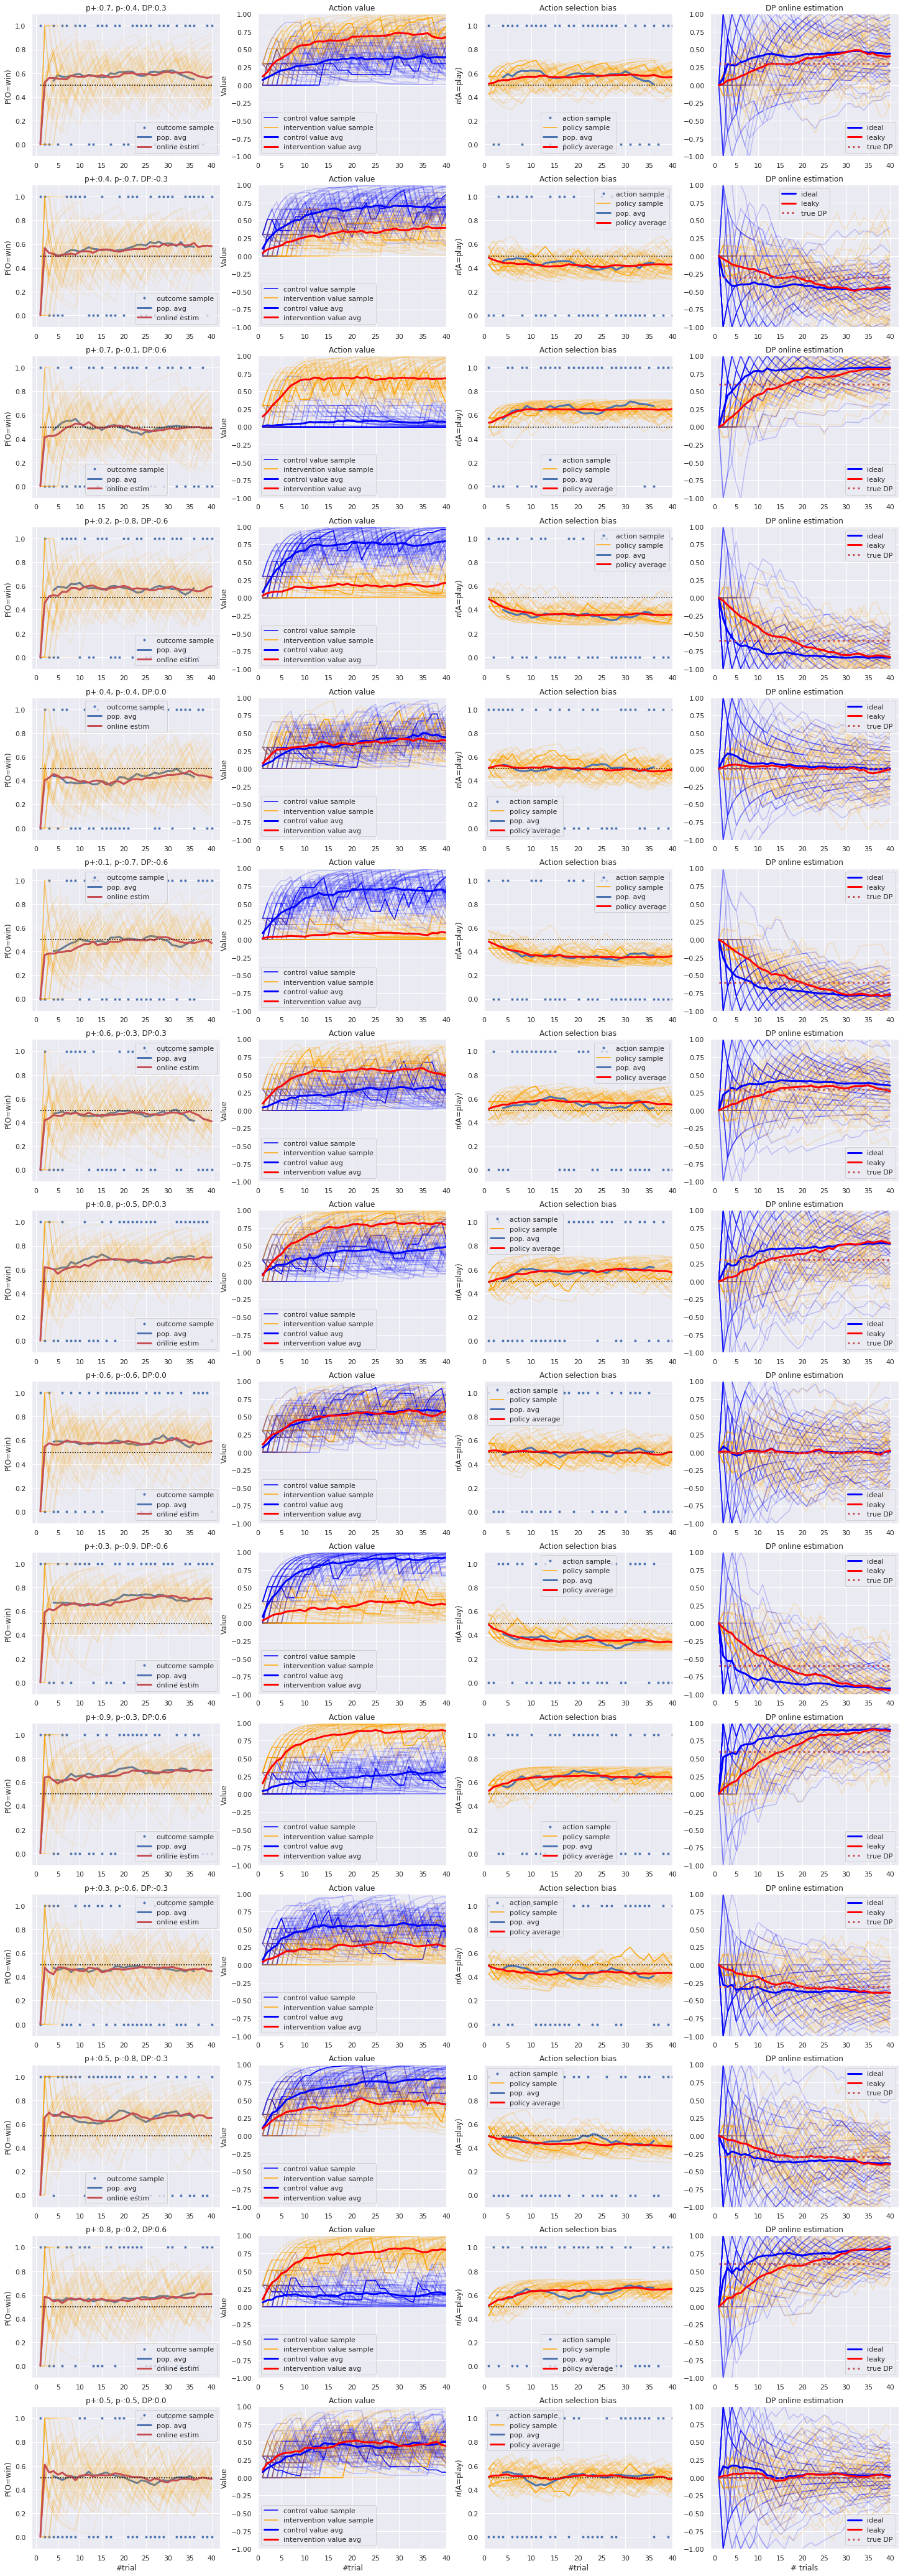

In [132]:
plt.figure(figsize=(25,5*15))
axis = range(1, NB_TRIALS+1)
for i, c_id in enumerate(sorted_keys): #conditions: 
    p_intervention = conditions[c_id][0]
    p_control = conditions[c_id][1]
    
    #### 1 ####
    ax=plt.subplot(15,4,4*i+1)    
    mean_reward = np.zeros(NB_TRIALS)
    for session in range(NB_SESSIONS):    
        if session == 0:
            ax.plot(axis, trainer[c_id, session].mem_total_reward,'.',label='outcome sample')
        mean_reward += np.array(trainer[c_id, session].mem_total_reward)/NB_SESSIONS

    ax.plot(range(4, NB_TRIALS-3), np.convolve(mean_reward, np.ones(6)/6)[6:-6], 'b', linewidth=3, label='pop. avg')
    ax.plot([1, NB_TRIALS], [0.5, 0.5],':k')
    ax.set_ylim([-0.1,1.1])
    if i == 14:
        ax.set_xlabel('#trial')
    ax.set_ylabel('P(O=win)')
    
    mean_mem_reward = np.zeros(NB_TRIALS)
    for session in range(NB_SESSIONS):    
        ax.plot(axis, mem_p_eff[c_id, session][1,:], c='orange', alpha=.1)
        mean_mem_reward += np.array(mem_p_eff[c_id, session][1,:])/NB_SESSIONS
    ax.plot(axis, mean_mem_reward, 'r', linewidth=3, label='online estim')
    ax.plot([1, NB_TRIALS], [0.5, 0.5],':k')
    ax.set_title(f'p+:{p_intervention}, p-:{p_control}, DP:{p_intervention-p_control:.1f}')
    ax.legend()
    
    #### 2 ####
    ax=plt.subplot(15,4,4*i+2)
    mean_Q_var_c = np.zeros(NB_TRIALS)
    mean_Q_var_i = np.zeros(NB_TRIALS)
    for session in range(NB_SESSIONS):    
        if session ==0:
            ax.plot(axis, mem_Q_var_flat[c_id, session][:,0], c='blue', label='control value sample')        
            ax.plot(axis, mem_Q_var_flat[c_id, session][:,1], c='orange', label='intervention value sample')
        else:
            ax.plot(axis, mem_Q_var_flat[c_id, session][:,0], c='blue', alpha=.2)        
            ax.plot(axis, mem_Q_var_flat[c_id, session][:,1], c='orange', alpha=.2)
        mean_Q_var_c += mem_Q_var_flat[c_id, session][:,0]/NB_SESSIONS
        mean_Q_var_i += mem_Q_var_flat[c_id, session][:,1]/NB_SESSIONS
    ax.plot(axis, mean_Q_var_c, label='control value avg', c='blue', linewidth=3)
    ax.plot(axis, mean_Q_var_i, label='intervention value avg', c='red', linewidth=3)
    ax.set_xlim(0,trainer[c_id, session].nb_trials)
    ax.legend()
    if i == 14:
        ax.set_xlabel('#trial')
    ax.set_ylabel('Value')
    ax.set_title('Action value')
    ax.set_ylim((-1,1))
    
    
    #### 3 ####
    ax=plt.subplot(15,4,4*i+3)
    mean_act = np.zeros(NB_TRIALS)
    for session in range(NB_SESSIONS):    
        #ax.plot(axis, mem_act[c_id, session],'.k',alpha=.2)
        mean_act += np.array(mem_act[c_id, session])/NB_SESSIONS
        pi = np.zeros((NB_TRIALS, env[c_id].N_act))
        for trial in range(NB_TRIALS):
            agent[c_id, session].Q_var_tab[0,:] = mem_Q_var_flat[c_id, session][trial,:]
            pi[trial,:] = agent[c_id, session].softmax(0)
        if session ==0:
            ax.plot(axis, mem_act[c_id, session],'.',label='action sample')
            ax.plot(axis, pi[:,1], c='orange', label='policy sample')
        else:
            ax.plot(axis, pi[:,1], c='orange', alpha=.2)
            
    mean_pi = np.zeros((NB_TRIALS, env[c_id].N_act))
    Q_mean = np.array([mean_Q_var_c, mean_Q_var_i]).transpose()
    for trial in range(NB_TRIALS):
        agent[c_id, session].Q_var_tab[0,:] = Q_mean[trial,:]
        mean_pi[trial,:] = agent[c_id, session].softmax(0)
    ax.plot(range(4, NB_TRIALS-3), np.convolve(mean_act, np.ones(6)/6)[6:-6], 'b', linewidth=3, label='pop. avg')
    ax.plot(axis, mean_pi[:,1], label='policy average', c='red', linewidth=3)
    ax.set_xlim(0,NB_TRIALS)
    ax.set_ylim((-0.1,1.1))
    ax.set_ylabel(r'$\pi$(A=play)')
    ax.plot([1, NB_TRIALS], [0.5, 0.5],':k')
    if i == 14:
        ax.set_xlabel('#trial')
    ax.set_title('Action selection bias')
    ax.legend()
   
    
    #### 4 ####
    ax=plt.subplot(15,4,4*i+4)
    mean_DP_ref = np.zeros(NB_TRIALS) 
    mean_DP_leak = np.zeros(NB_TRIALS) 
    axis = np.arange(1, NB_TRIALS+1)
    for session in range(NB_SESSIONS):
        true_DP = p_intervention - p_control 
        ax.plot(axis, mem_DP_ref[c_id, session], c='blue', alpha=.2)
        mean_DP_ref += np.array(mem_DP_ref[c_id, session]) / NB_SESSIONS
        ax.plot(axis, mem_DP_leak[c_id, session], c='orange', alpha=.2)   
        mean_DP_leak += np.array(mem_DP_leak[c_id, session]) / NB_SESSIONS
    ax.plot(axis, mean_DP_ref, c='blue',  label='ideal', linewidth=3)
    ax.plot(axis, mean_DP_leak, c='red',  label='leaky', linewidth=3)
    ax.plot([1,NB_TRIALS], [true_DP, true_DP], ':r', label='true DP', linewidth=3)
    ax.set_ylim([-1,1])
    if i == 14:
        ax.set_xlabel("# trials")
    ax.set_title(f'DP online estimation')
    ax.legend()
plt.savefig(f'VolleyBallEndEffect_k_{k}.pdf', bbox_inches='tight')

In [133]:
import xarray as xr
win_data = xr.load_dataset("Win_behav_file.nc")
play_data = xr.load_dataset("Play_behav_file.nc")
win_data.sel(team = 1).__xarray_dataarray_variable__.data

array([0.6       , 0.66666667, 0.73333333, 0.6       , 0.26666667,
       0.66666667, 0.66666667, 0.46666667, 0.53333333, 0.53333333,
       0.73333333, 0.46666667, 0.66666667, 0.6       , 0.53333333,
       0.6       , 0.46666667, 0.53333333, 0.4       , 0.6       ,
       0.6       , 0.6       , 0.46666667, 0.6       , 0.46666667,
       0.53333333, 0.6       , 0.4       , 0.53333333, 0.46666667,
       0.53333333, 0.53333333, 0.73333333, 0.66666667, 0.66666667,
       0.66666667, 0.4       , 0.6       , 0.53333333, 0.53333333])

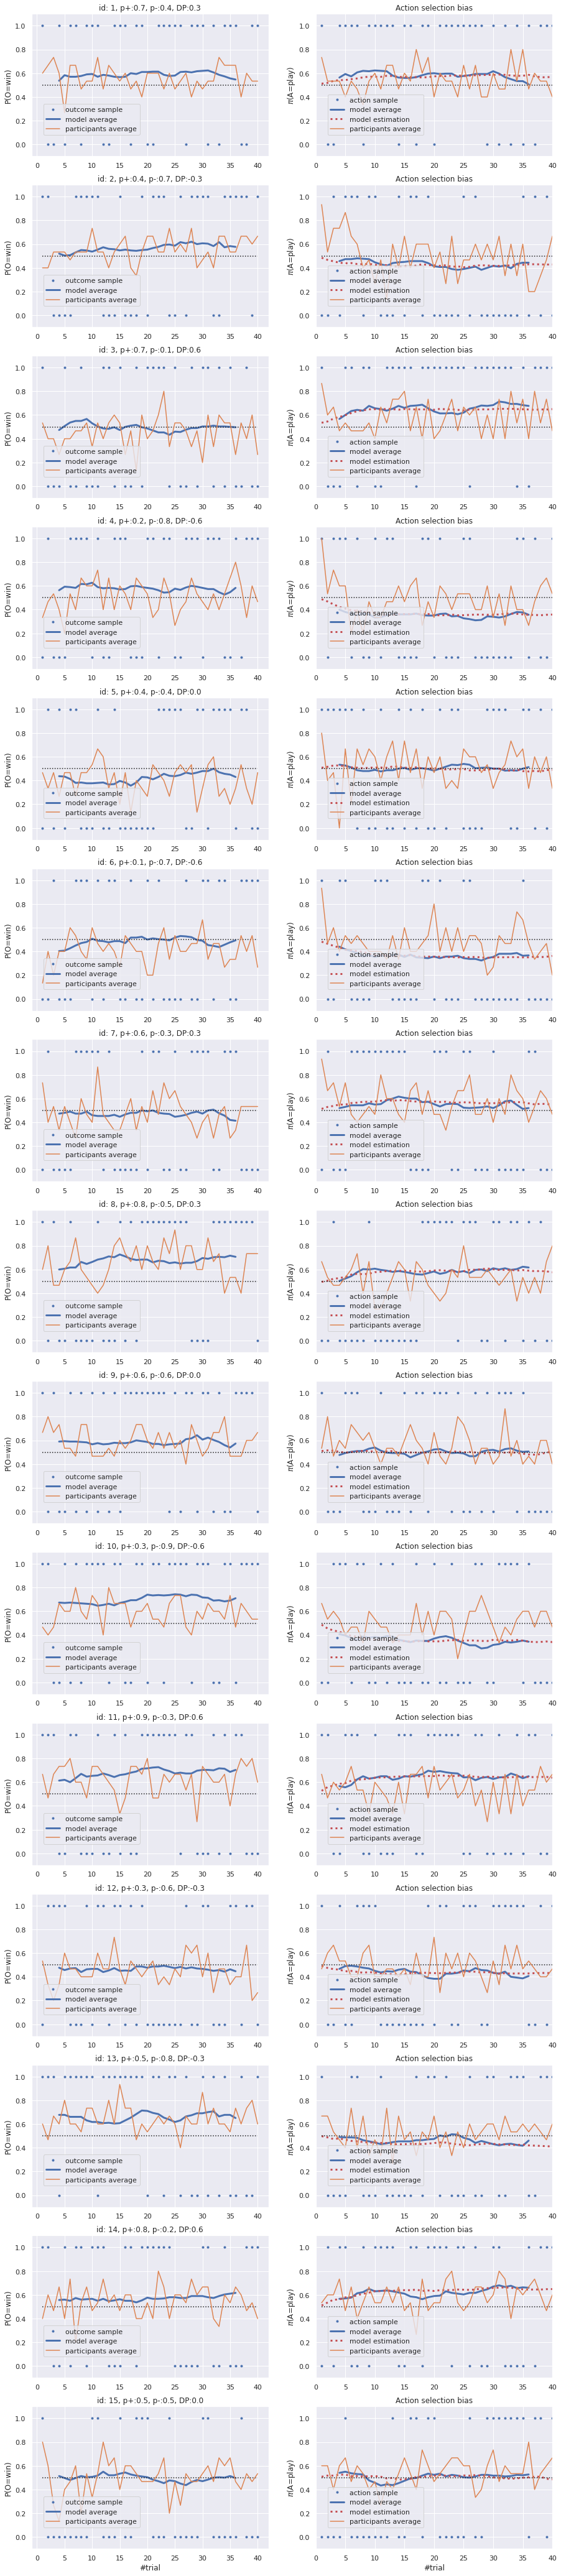

In [134]:
plt.figure(figsize=(15,5*15))
axis = range(1, NB_TRIALS+1)
for i, c_id in enumerate(sorted_keys): #conditions: 
    p_intervention = conditions[c_id][0]
    p_control = conditions[c_id][1]
    
    #### 1 ####
    ax=plt.subplot(15,2,2*i+1)    
    mean_reward = np.zeros(NB_TRIALS)
    for session in range(NB_SESSIONS):    
        if session == 0:
            ax.plot(axis, trainer[c_id, session].mem_total_reward,'.',label='outcome sample')
        mean_reward += np.array(trainer[c_id, session].mem_total_reward)/NB_SESSIONS

    ax.plot(range(4, NB_TRIALS-3), np.convolve(mean_reward, np.ones(6)/6)[6:-6], 'b', linewidth=3, label='model average')
    ax.plot([1, NB_TRIALS], [0.5, 0.5],':k')
    ax.set_ylim([-0.1,1.1])
    if i == 14:
        ax.set_xlabel('#trial')
    ax.set_ylabel('P(O=win)')
    
    mean_mem_reward = np.zeros(NB_TRIALS)
    for session in range(NB_SESSIONS):    
        #ax.plot(axis, mem_p_eff[c_id, session][1,:], c='orange', alpha=.1)
        mean_mem_reward += np.array(mem_p_eff[c_id, session][1,:])/NB_SESSIONS
    #ax.plot(axis, mean_mem_reward, 'r', linewidth=3, label='online estim')
    ax.set_title(f'id: {c_id}, p+:{p_intervention}, p-:{p_control}, DP:{p_intervention-p_control:.1f}')
    ax.plot(axis, win_data.sel(team = c_id).__xarray_dataarray_variable__.data, label='participants average')
    ax.legend(loc=(0.05,0.15))
    
    
    #### 2 ####
    # ax=plt.subplot(15,4,4*i+2)
    mean_Q_var_c = np.zeros(NB_TRIALS)
    mean_Q_var_i = np.zeros(NB_TRIALS)
    for session in range(NB_SESSIONS):    
        # if session ==0:
            # ax.plot(axis, mem_Q_var_flat[c_id, session][:,0], c='blue', label='control value sample')        
            # ax.plot(axis, mem_Q_var_flat[c_id, session][:,1], c='orange', label='intervention value sample')
        # else:
            # ax.plot(axis, mem_Q_var_flat[c_id, session][:,0], c='blue', alpha=.2)        
            # ax.plot(axis, mem_Q_var_flat[c_id, session][:,1], c='orange', alpha=.2)
        mean_Q_var_c += mem_Q_var_flat[c_id, session][:,0]/NB_SESSIONS
        mean_Q_var_i += mem_Q_var_flat[c_id, session][:,1]/NB_SESSIONS
    # ax.plot(axis, mean_Q_var_c, label='control value avg', c='blue', linewidth=3)
    # ax.plot(axis, mean_Q_var_i, label='intervention value avg', c='red', linewidth=3)
    # ax.set_xlim(0,trainer[c_id, session].nb_trials)
    # ax.legend()
    # if i == 14:
    #    ax.set_xlabel('#trial')
    # ax.set_ylabel('Value')
    # ax.set_title('Action value')
    # ax.set_ylim((-1,1))
    
    
    #### 3 ####
    ax=plt.subplot(15,2,2*i+2)
    mean_act = np.zeros(NB_TRIALS)
    for session in range(NB_SESSIONS):    
        # ax.plot(axis, mem_act[c_id, session],'.k',alpha=.2)
        mean_act += np.array(mem_act[c_id, session])/NB_SESSIONS
        pi = np.zeros((NB_TRIALS, env[c_id].N_act))
        for trial in range(NB_TRIALS):
            agent[c_id, session].Q_var_tab[0,:] = mem_Q_var_flat[c_id, session][trial,:]
            pi[trial,:] = agent[c_id, session].softmax(0)
        if session ==0:
            ax.plot(axis, mem_act[c_id, session],'.',label='action sample')
        #    ax.plot(axis, pi[:,1], c='orange', label='policy sample')
        # else:
        #    ax.plot(axis, pi[:,1], c='orange', alpha=.2)
            
    mean_pi = np.zeros((NB_TRIALS, env[c_id].N_act))
    Q_mean = np.array([mean_Q_var_c, mean_Q_var_i]).transpose()
    for trial in range(NB_TRIALS):
        agent[c_id, session].Q_var_tab[0,:] = Q_mean[trial,:]
        mean_pi[trial,:] = agent[c_id, session].softmax(0)
    ax.plot(range(4, NB_TRIALS-3), np.convolve(mean_act, np.ones(6)/6)[6:-6], 'b', linewidth=3, label='model average')
    ax.plot(axis, mean_pi[:,1], 'r:', label='model estimation', linewidth=3)
    ax.set_xlim(0,NB_TRIALS)
    ax.set_ylim((-0.1,1.1))
    ax.set_ylabel(r'$\pi$(A=play)')
    ax.plot([1, NB_TRIALS], [0.5, 0.5],':k')
    if i == 14:
        ax.set_xlabel('#trial')
    ax.set_title('Action selection bias')
    
    ax.plot(axis, play_data.sel(team = c_id).__xarray_dataarray_variable__.data, label='participants average')
    ax.legend(loc=(0.05,0.15))
   
    
    #### 4 ####
    '''ax=plt.subplot(15,4,4*i+4)
    mean_DP_ref = np.zeros(NB_TRIALS) 
    mean_DP_leak = np.zeros(NB_TRIALS) 
    axis = np.arange(1, NB_TRIALS+1)
    for session in range(NB_SESSIONS):
        true_DP = p_intervention - p_control 
        ax.plot(axis, mem_DP_ref[c_id, session], c='blue', alpha=.2)
        mean_DP_ref += np.array(mem_DP_ref[c_id, session]) / NB_SESSIONS
        ax.plot(axis, mem_DP_leak[c_id, session], c='orange', alpha=.2)   
        mean_DP_leak += np.array(mem_DP_leak[c_id, session]) / NB_SESSIONS
    ax.plot(axis, mean_DP_ref, c='blue',  label='ideal', linewidth=3)
    ax.plot(axis, mean_DP_leak, c='red',  label='leaky', linewidth=3)
    ax.plot([1,NB_TRIALS], [true_DP, true_DP], ':r', label='true DP', linewidth=3)
    ax.set_ylim([-1,1])
    if i == 14:
        ax.set_xlabel("# trials")
    ax.set_title(f'DP online estimation')
    ax.legend()'''
plt.savefig(f'VolleyBallEndEffect_s_k_{k}.pdf', bbox_inches='tight')

In [135]:
trainer[c_id, session].action_history

[1]

KeyError: 0

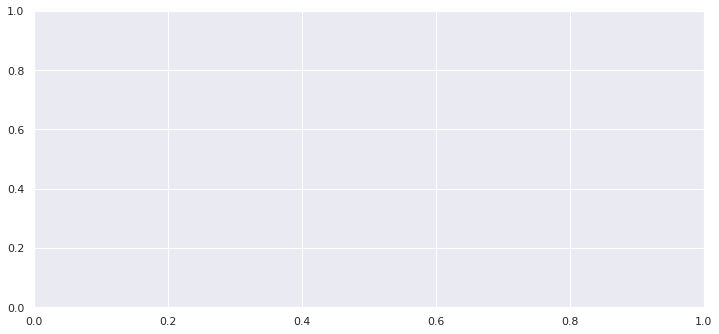

In [136]:
plt.figure(figsize=(12,12))
ax=plt.subplot(211)
mean_reward = np.zeros(NB_TRIALS)
for session in range(NB_SESSIONS):    
    #ax.plot(trainer[session].mem_total_reward[session],'.',alpha=.1)
    mean_reward += np.array(trainer[session].mem_total_reward)/NB_SESSIONS

ax.plot(range(4, NB_TRIALS-3), np.convolve(mean_reward, np.ones(6)/6)[6:-6], 'r', linewidth=3)
ax.plot([1, NB_TRIALS], [0.5, 0.5],':k')
ax.set_ylim([0,1])
ax.set_xlabel('#trial')
ax.set_ylabel('Outcome')
ax.set_title('Outcome')
ax=plt.subplot(212)

mean_mem_reward = np.zeros(NB_TRIALS)
for session in range(NB_SESSIONS):    
    ax.plot(axis, mem_p_eff[session][1,:], c='orange', alpha=.1)
    mean_mem_reward += np.array(mem_p_eff[session][1,:])/NB_SESSIONS
ax.plot(axis, mean_mem_reward, 'r', linewidth=3)
ax.plot([1, NB_TRIALS], [0.5, 0.5],':k')
#ax.set_ylim(0,.2)
plt.title('Online outcome estimate')


In [ ]:
plt.figure(figsize=(20,4))
ax=plt.subplot(111)
ax.plot(mem_KL)
ax.set_ylim(2,-2)
ax.set_xlim(0,trainer.nb_trials)

In [ ]:
trial=0
v_min=0
v_max = 0.16
savefigs = False

In [ ]:
plt.figure(figsize = (12,3))
ax = plt.subplot(1,2,1)
plt.bar(range(env.N_obs), nb_visits_final[trial] / N)
ax.set_xticks(range(env.N_obs))
plt.xlabel('Final states')
plt.ylabel('State visit density')
#plt.ylim([0,0.17])
plt.title('Uniform effect drive')

ax = plt.subplot(1,2,2)
plt.imshow(nb_visits_final[trial]/ N, vmin=v_min, vmax=v_max)
for j in range(6):
    for i in range(3):
        plt.text(j,i,6*i+j)

ax.set_xticks([])
ax.set_yticks([])
plt.title('Uniform effect drive')


In [ ]:
trainer.nb_trials

In [ ]:
obs_nb_visit = np.zeros((env.N_obs, trainer.nb_trials))
obs_p = np.zeros((env.N_obs, trainer.nb_trials))
for obs in range(env.N_obs):
    obs_nb_visit[obs,:] = np.cumsum(np.array(trainer.mem_obs_final)==obs)
    obs_p[obs,:] = np.cumsum(np.array(trainer.mem_obs_final)==obs) / (np.arange(trainer.nb_trials)+1)
    

In [ ]:
_ = plt.plot(obs_nb_visit.T)

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(obs_p.T)
plt.ylim((0,0.2))

In [ ]:
plt.plot(trainer.obs_score)

In [ ]:
trainer.ref_probs

In [ ]:
plt.figure(figsize=(15,4))
_ = plt.imshow(mem_obs_score, aspect='auto', interpolation='nearest')

In [ ]:
plt.figure(figsize=(15,4))
_ = plt.imshow(mem_p_eff, aspect='auto', interpolation='nearest', vmin=0, vmax=0.2)

In [ ]:
plt.figure(figsize=(15,4))
ax=plt.subplot(111)
ax.plot(range(2500,3000), mem_KL[2500:3000])
#ax.set_ylim(1,-1)
#ax.set_xlim(4500,5000)

In [ ]:
#obs = trainer.agent.get_observation()
plt.figure(figsize=(15,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
for obs in range(7):
    actions_set = None #trainer.set_actions_set()
    #print(actions_set)
    Q_obs = trainer.agent.set_Q_obs(obs, actions_set = actions_set)
    ax1.plot(Q_obs,'k',alpha=.5)    
    ax1.set_title('Q_VAR') # : MEAN RTG :' + str(m_rtg))
    ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', alpha=.5)
#ax1.plot((1,trainer.N_PART), (m_rtg, m_rtg), 'r')
ax1.plot(Q_obs,'k',linewidth=3)
ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', linewidth=3)

## TRIAL

In [ ]:
%matplotlib tk
#agent.env=env
trainer.run_episode(render=True)

%matplotlib inline
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(trainer.reward_history)
plt.ylim(-1,1)
plt.title('TRIAL : REWARD')
plt.subplot(1,3,2)
plt.plot(trainer.trajectory)
print(trainer.total_reward)
plt.title('TRIAL : OBS')
plt.subplot(1,3,3)
plt.plot(trainer.action_history)
plt.title('TRIAL : ACTION')
#obs = trainer.agent.get_observation()


In [ ]:
%matplotlib tk

In [ ]:
plt.plot(np.random.randn(100))

In [ ]:
plt.close('all')